In [1]:
import os
#os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "2"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
import numpy as np

2023-06-20 10:51:13.899779: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 10:51:13.938050: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 10:51:13.938574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 10:51:14.515994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.chdir('./dataset/')

In [3]:
filenames = os.listdir('./')
filenames.sort()
files_to_append = filenames[7:13]
del filenames[7:13]
for file in files_to_append:
    filenames.append(file)
filenames

['model_step1.hdf5',
 'subject-1-T1.hdr',
 'subject-1-T1.img',
 'subject-1-T2.hdr',
 'subject-1-T2.img',
 'subject-1-label.hdr',
 'subject-1-label.img',
 'subject-2-T1.hdr',
 'subject-2-T1.img',
 'subject-2-T2.hdr',
 'subject-2-T2.img',
 'subject-2-label.hdr',
 'subject-2-label.img',
 'subject-3-T1.hdr',
 'subject-3-T1.img',
 'subject-3-T2.hdr',
 'subject-3-T2.img',
 'subject-3-label.hdr',
 'subject-3-label.img',
 'subject-4-T1.hdr',
 'subject-4-T1.img',
 'subject-4-T2.hdr',
 'subject-4-T2.img',
 'subject-4-label.hdr',
 'subject-4-label.img',
 'subject-5-T1.hdr',
 'subject-5-T1.img',
 'subject-5-T2.hdr',
 'subject-5-T2.img',
 'subject-5-label.hdr',
 'subject-5-label.img',
 'subject-6-T1.hdr',
 'subject-6-T1.img',
 'subject-6-T2.hdr',
 'subject-6-T2.img',
 'subject-6-label.hdr',
 'subject-6-label.img',
 'subject-7-T1.hdr',
 'subject-7-T1.img',
 'subject-7-T2.hdr',
 'subject-7-T2.img',
 'subject-7-label.hdr',
 'subject-7-label.img',
 'subject-8-T1.hdr',
 'subject-8-T1.img',
 'subject-8-T

In [4]:
plt.style.use('dark_background')
%pylab inline

TRAINING_MODE = True
NB_EPOCHS_MAX = 100

Populating the interactive namespace from numpy and matplotlib


In [5]:
def fast_display(*img2dlst):
    plt.figure(figsize=(16, 8))
    nbimg = len(img2dlst)
    cols = min(9, nbimg)
    rows = (nbimg // cols) + 1
    for ii, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, 1+ii)
        plt.imshow(img2d)
    plt.show()

In [6]:
def PrintSlices(img):
    sx, sy, sz, _ = img.shape
    fast_display(img[sx//2,:, :, 0], img[:, sy//2, :, 0], img[:, :, sz//2, 0])

New patient :  subject-1-label.img
T1 : Coupes sagittale, coronale, axiale de subject-1-label.img


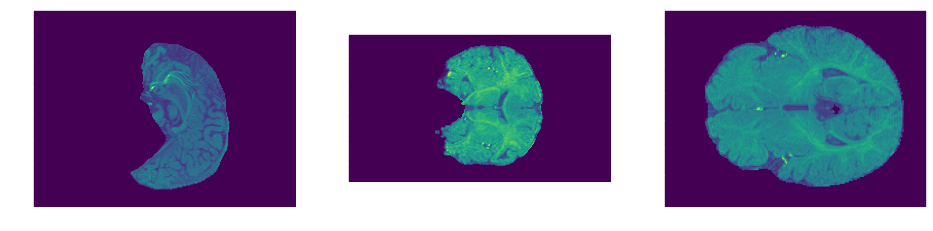

T2 : Coupes sagittale, coronale, axiale de subject-1-label.img


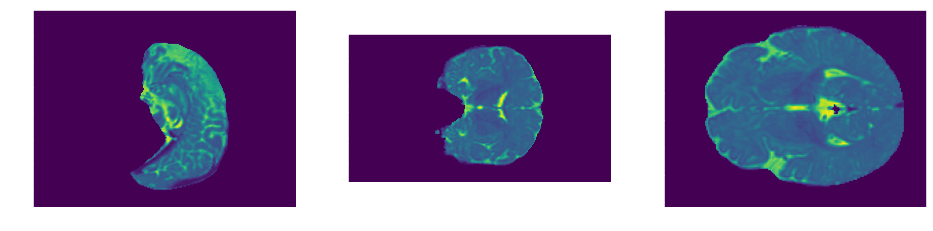

LABELS : Coupes sagittale, coronale, axiale de subject-1-label.img


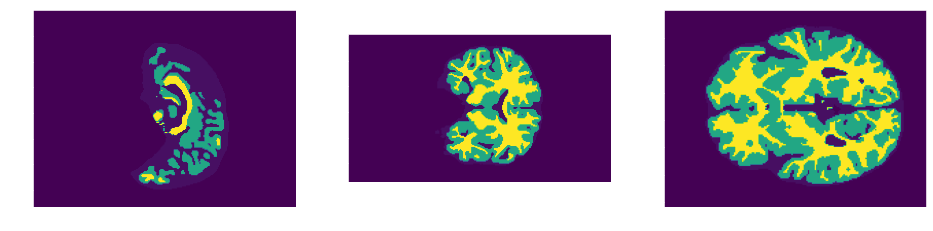

New patient :  subject-2-label.img
New patient :  subject-3-label.img
New patient :  subject-4-label.img
New patient :  subject-5-label.img
New patient :  subject-6-label.img
New patient :  subject-7-label.img
New patient :  subject-8-label.img
New patient :  subject-9-label.img
New patient :  subject-10-label.img


In [7]:
nb_patient = 0
for filename in filenames:
    if "label" in filename and "hdr" not in filename:
        print("New patient : ", filename)   
        nomT1 = filename[:-10] + "-T1.img"
        T1 = nib.load(nomT1).get_fdata()
        if nb_patient == 0:
            print("T1 : Coupes sagittale, coronale, axiale de", filename)
            PrintSlices(T1)
            
        nomT2 = filename[:-10] + "-T2.img"
        T2 = nib.load(nomT2).get_fdata()
        if nb_patient == 0:
            print("T2 : Coupes sagittale, coronale, axiale de", filename)
            PrintSlices(T2)
            
        labels = nib.load(filename).get_fdata()
        if nb_patient == 0:
            print("LABELS : Coupes sagittale, coronale, axiale de", filename)
            PrintSlices(labels)
            
        nb_patient += 1

In [8]:
def ComputeDice(X, Y):
    Xbin = X > 0
    Ybin = Y > 0
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    
    print("CardIntersec =", cardIntersec)
    print("CardX =", cardX)
    print("CardY =", cardY)
    
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec) / (cardX + cardY)
        print("Dice = ", dice)
        return dice
    else:
        return 0

In [9]:
def Normalisation(img):
    mu = np.mean(img[img > 0])
    sigma = np.std(img[img > 0])
    return ((img - mu) / sigma)

In [10]:
nb_patient_training = 6
nb_patient_validation = 2
nb_patient_test = 2
print(nb_patient)

10


In [11]:
threashold_area = 100
nb_intersting_slices_training = 0
nb_intersting_slices_validation = 0
num_patient = 0

for filename in filenames:
    if "label" in filename and "hdr" not in filename:
        if (num_patient < nb_patient_training) or (num_patient >= nb_patient_training and num_patient < nb_patient_training + nb_patient_validation):
            if num_patient < nb_patient_training:
                print("PATIENT (training):", filename)
            else:
                print("PATIENT (validation):", filename)
            labels = nib.load(filename).get_fdata()
            sx, sy, sz, _ = labels.shape
            labels = np.array(labels).reshape((sx, sy, sz))
            
            for z in range(0, sz):
                slice = labels[:, :, z]
                if np.sum(slice >= 0) >= threashold_area:
                    if num_patient < nb_patient_training:
                        nb_intersting_slices_training += 1
                    if num_patient >= nb_patient_training and num_patient < nb_patient_training + nb_patient_validation:
                        nb_intersting_slices_validation += 1
            num_patient += 1
            
print("Number of intersting slices for training:", nb_intersting_slices_training)
print("Number of intersting slices for validation:", nb_intersting_slices_validation)

PATIENT (training): subject-1-label.img
PATIENT (training): subject-2-label.img
PATIENT (training): subject-3-label.img
PATIENT (training): subject-4-label.img
PATIENT (training): subject-5-label.img
PATIENT (training): subject-6-label.img
PATIENT (validation): subject-7-label.img
PATIENT (validation): subject-8-label.img
Number of intersting slices for training: 1536
Number of intersting slices for validation: 512


In [12]:
x_train = np.zeros((nb_intersting_slices_training, sx, sy, 2))
y_train = np.zeros((nb_intersting_slices_training, sx, sy, 1))

x_valid = np.zeros((nb_intersting_slices_validation, sx, sy, 2))
y_valid = np.zeros((nb_intersting_slices_validation, sx, sy, 1))

In [13]:
numero_intersting_slices_training = 0
numero_intersting_slices_validation = 0
num_patient = 0

for filename in filenames:
    if "label" in filename and "hdr" not in filename:
        if (num_patient < nb_patient_training) or (num_patient >= nb_patient_training and num_patient < nb_patient_training + nb_patient_validation):
            if num_patient < nb_patient_training:
                print("PATIENT (training):", filename)
            else:
                print("PATIENT (validation):", filename)
            T1_name = filename[:-10] + "-T1.img"
            T1 = nib.load(T1_name).get_fdata()
            T2_name = filename[:-10] + "-T2.img"
            T2 = nib.load(T2_name).get_fdata()
            labels = nib.load(filename).get_fdata()
            
            sx, sy, sz, _ = labels.shape
            labels = np.array(labels).reshape((sx, sy, sz))
            
            T1_normalized = Normalisation(T1).reshape((sx, sy, sz))
            T2_normalized = Normalisation(T2).reshape((sx, sy, sz))
            labels_clipped = np.clip(labels, 0, 1).reshape((sx, sy, sz))
            vt3d = np.where(labels >= 10, 1, 0)
            
            for z in range(0, sz):
                slice = labels[:, :, z]
                if np.sum(slice >= 0) >= threashold_area:
                    if num_patient < nb_patient_training:
                        x_train[numero_intersting_slices_training, :, :, 0] = T1_normalized[:, :, z]
                        x_train[numero_intersting_slices_training, :, :, 1] = T1_normalized[:, :, z]
                        y_train[numero_intersting_slices_training, :, :, 0] = labels_clipped[:, : ,z]
                        numero_intersting_slices_training += 1
                            
                    if num_patient >= nb_patient_training and num_patient < nb_patient_training + nb_patient_validation:
                        x_valid[numero_intersting_slices_validation, :, :, 0] = T1_normalized[:, :, z]
                        x_valid[numero_intersting_slices_validation, :, :, 1] = T1_normalized[:, :, z]
                        y_valid[numero_intersting_slices_validation, :, :, 0] = vt3d[:, :, z]
                        numero_intersting_slices_validation += 1                            
        num_patient += 1

PATIENT (training): subject-1-label.img
PATIENT (training): subject-2-label.img
PATIENT (training): subject-3-label.img
PATIENT (training): subject-4-label.img
PATIENT (training): subject-5-label.img
PATIENT (training): subject-6-label.img
PATIENT (validation): subject-7-label.img
PATIENT (validation): subject-8-label.img


In [14]:
np.unique(labels)

array([  0.,  10., 150., 250.])

In [15]:
from PIL import Image
from tensorflow.keras import Input, Model
from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

nbf64 = 8
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet_step_1(input_size = (sx, sy, 2)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(nbf1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(nbf1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(nbf512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(nbf256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(nbf128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(nbf64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    
    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [16]:
model_step1 = unet_step_1()

2023-06-20 10:51:24.359398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 10:51:24.380576: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 192, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 192, 8)  152         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 144, 192, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 72, 96, 8)    0           ['conv2d_1[0][0]']           

 conv2d_22 (Conv2D)             (None, 144, 192, 2)  146         ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_23 (Conv2D)             (None, 144, 192, 1)  3           ['conv2d_22[0][0]']              
                                                                                                  
Total params: 485,885
Trainable params: 485,885
Non-trainable params: 0
__________________________________________________________________________________________________


In [17]:
if TRAINING_MODE:
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True)

    model_step1.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        epochs=NB_EPOCHS_MAX,
        verbose=1,
        callbacks=[early_stopping],
        initial_epoch=0,
        validation_data=(x_valid, y_valid))
    model_step1.save_weights("./model_step1.hdf5")
else:
    model_step1.load_weights("./model_step1.hdf5")

Epoch 1/100
48/48 [==============================] - 65s 1s/step - loss: 0.1243 - accuracy: 0.9169 - val_loss: 0.0904 - val_accuracy: 0.9680
Epoch 2/100
48/48 [==============================] - 62s 1s/step - loss: 0.0541 - accuracy: 0.9911 - val_loss: 0.0214 - val_accuracy: 0.9951
Epoch 3/100
48/48 [==============================] - 61s 1s/step - loss: 0.0100 - accuracy: 0.9968 - val_loss: 0.0158 - val_accuracy: 0.9955
Epoch 4/100
48/48 [==============================] - 62s 1s/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.0114 - val_accuracy: 0.9965
Epoch 5/100
48/48 [==============================] - 62s 1s/step - loss: 0.0063 - accuracy: 0.9977 - val_loss: 0.0116 - val_accuracy: 0.9963
Epoch 6/100
48/48 [==============================] - 62s 1s/step - loss: 0.0056 - accuracy: 0.9979 - val_loss: 0.0144 - val_accuracy: 0.9954
Epoch 7/100
48/48 [==============================] - 62s 1s/step - loss: 0.0052 - accuracy: 0.9980 - val_loss: 0.0101 - val_accuracy: 0.9965
Epoch 8/100
4

Epoch 59/100
48/48 [==============================] - 63s 1s/step - loss: 9.9404e-04 - accuracy: 0.9997 - val_loss: 0.0030 - val_accuracy: 0.9988
Epoch 60/100
48/48 [==============================] - 63s 1s/step - loss: 9.8020e-04 - accuracy: 0.9997 - val_loss: 0.0025 - val_accuracy: 0.9990
Epoch 61/100
48/48 [==============================] - 63s 1s/step - loss: 9.5261e-04 - accuracy: 0.9997 - val_loss: 0.0030 - val_accuracy: 0.9988
Epoch 62/100
48/48 [==============================] - 63s 1s/step - loss: 9.3895e-04 - accuracy: 0.9997 - val_loss: 0.0028 - val_accuracy: 0.9989
Epoch 63/100
48/48 [==============================] - 63s 1s/step - loss: 9.1119e-04 - accuracy: 0.9997 - val_loss: 0.0027 - val_accuracy: 0.9989
Epoch 64/100
48/48 [==============================] - 63s 1s/step - loss: 8.8612e-04 - accuracy: 0.9997 - val_loss: 0.0028 - val_accuracy: 0.9989
Epoch 65/100
48/48 [==============================] - 63s 1s/step - loss: 8.7315e-04 - accuracy: 0.9997 - val_loss: 0.0031 -

PATIENT (test): subject-1-label.img
T1, T2, Prediction, Verite Terrain


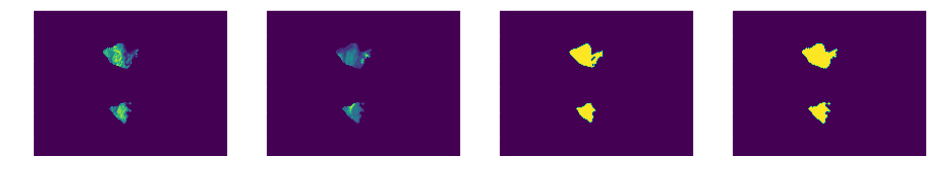

T1, T2, Prediction, Verite Terrain


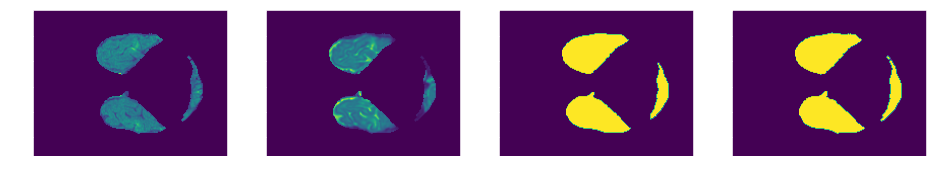

T1, T2, Prediction, Verite Terrain


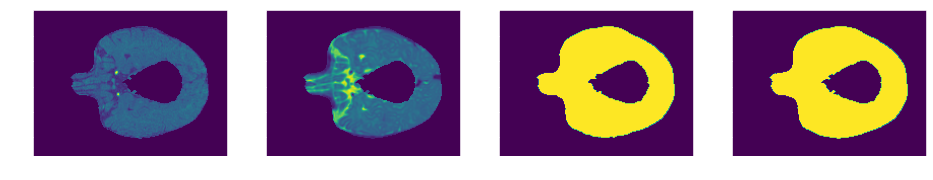

T1, T2, Prediction, Verite Terrain


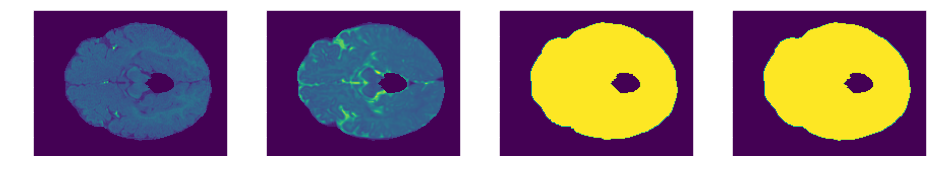

T1, T2, Prediction, Verite Terrain


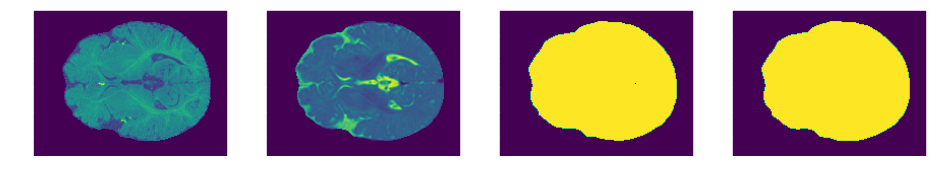

T1, T2, Prediction, Verite Terrain


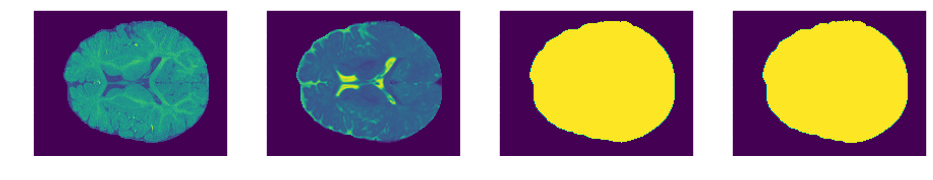

T1, T2, Prediction, Verite Terrain


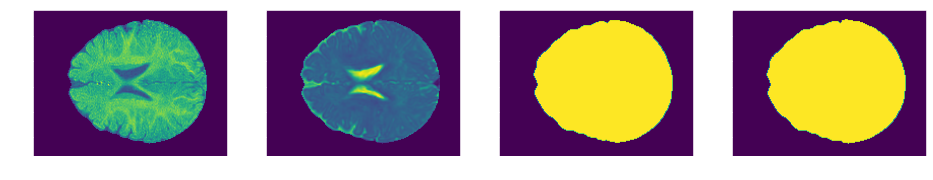

T1, T2, Prediction, Verite Terrain


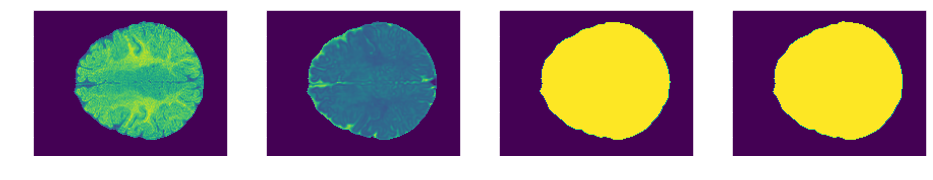

T1, T2, Prediction, Verite Terrain


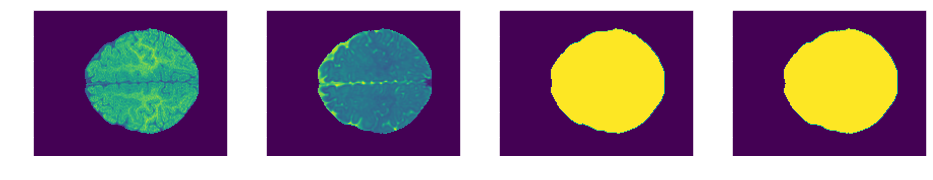

T1, T2, Prediction, Verite Terrain


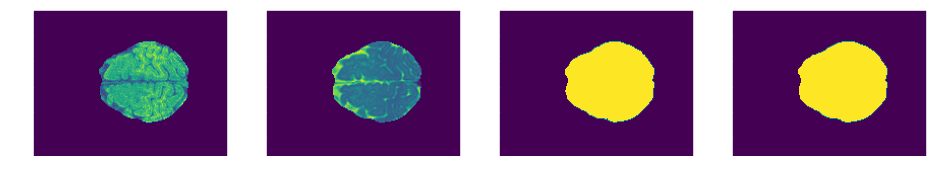

T1, T2, Prediction, Verite Terrain


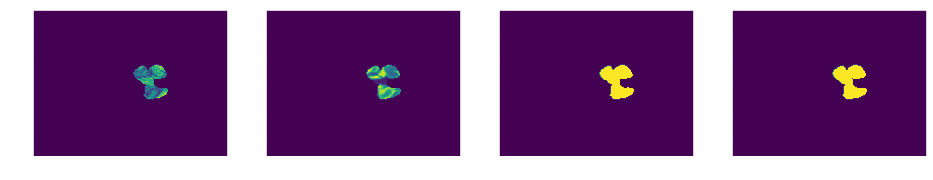

CardIntersec = 914724
CardX = 914980
CardY = 921422
Dice =  0.9962132474262171
PATIENT (test): subject-2-label.img
T1, T2, Prediction, Verite Terrain


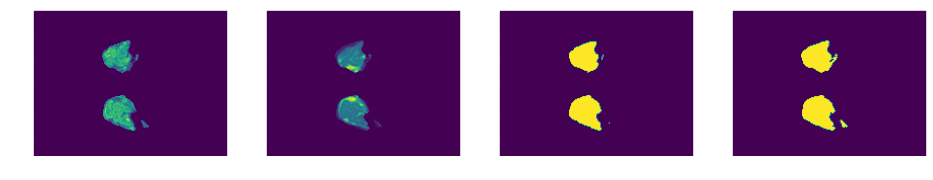

T1, T2, Prediction, Verite Terrain


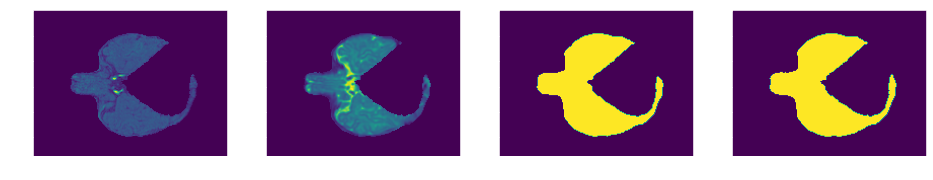

T1, T2, Prediction, Verite Terrain


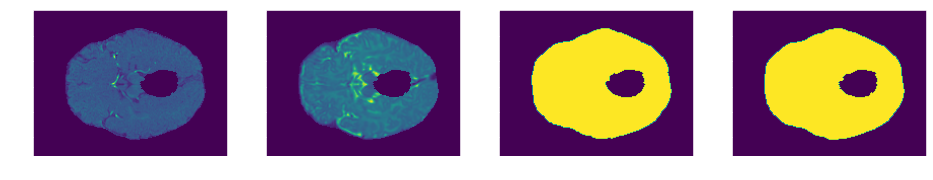

T1, T2, Prediction, Verite Terrain


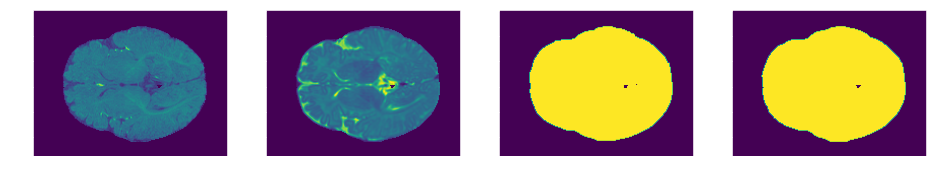

T1, T2, Prediction, Verite Terrain


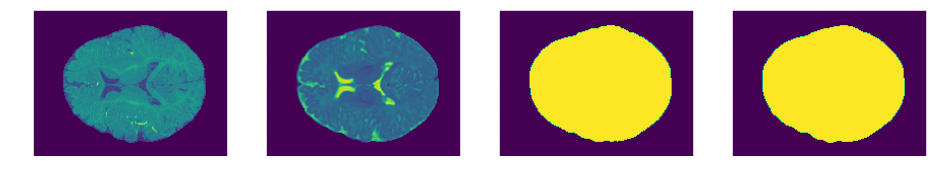

T1, T2, Prediction, Verite Terrain


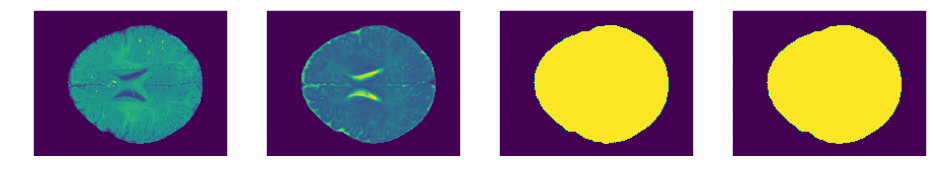

T1, T2, Prediction, Verite Terrain


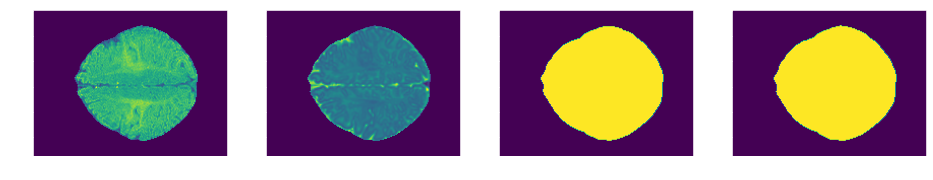

T1, T2, Prediction, Verite Terrain


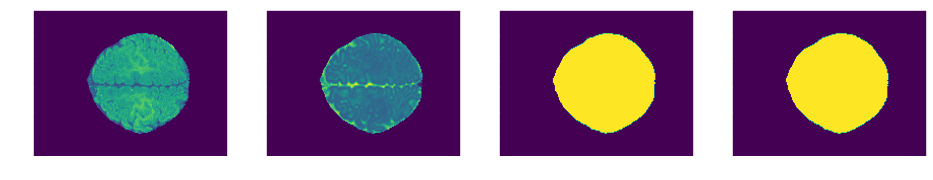

T1, T2, Prediction, Verite Terrain


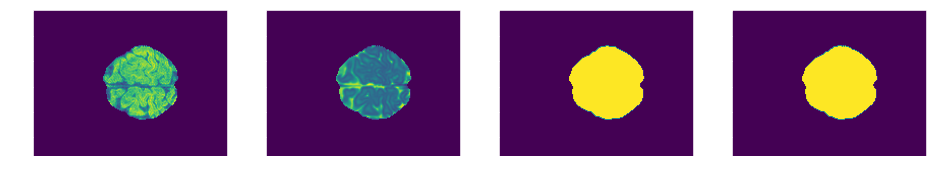

T1, T2, Prediction, Verite Terrain


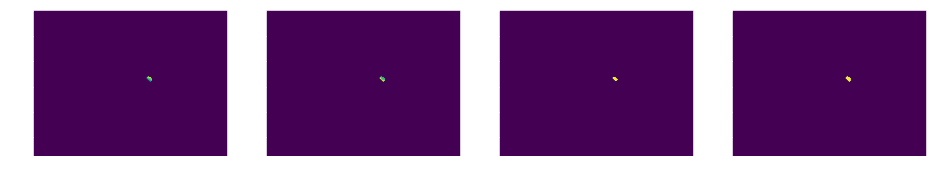

CardIntersec = 756089
CardX = 756230
CardY = 762015
Dice =  0.9960039387582373
PATIENT (test): subject-3-label.img
T1, T2, Prediction, Verite Terrain


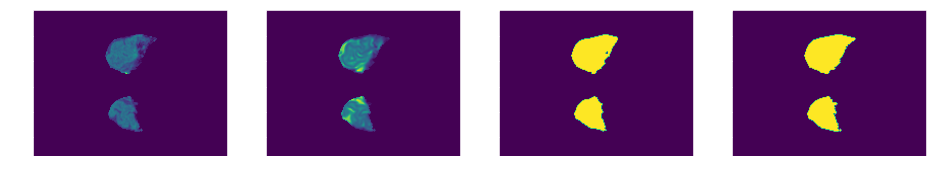

T1, T2, Prediction, Verite Terrain


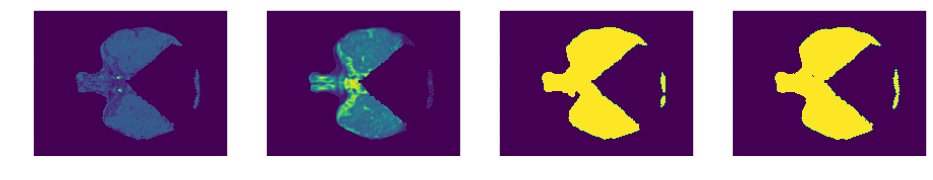

T1, T2, Prediction, Verite Terrain


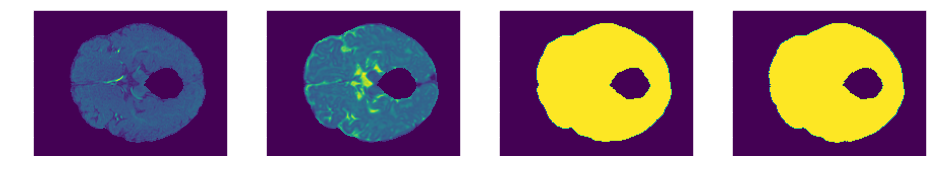

T1, T2, Prediction, Verite Terrain


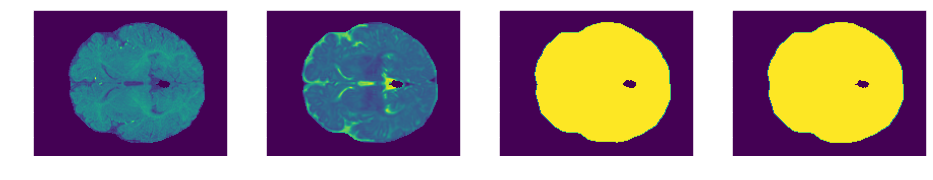

T1, T2, Prediction, Verite Terrain


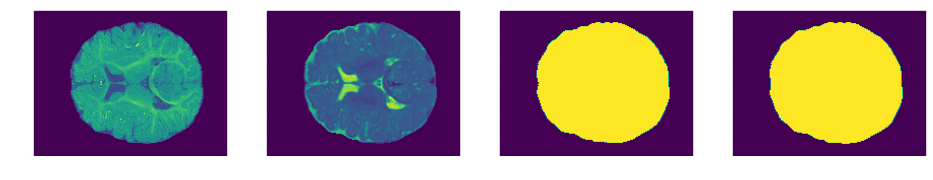

T1, T2, Prediction, Verite Terrain


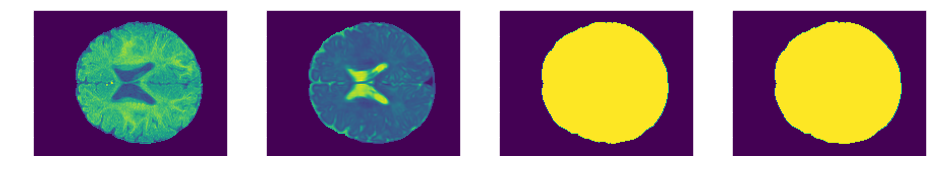

T1, T2, Prediction, Verite Terrain


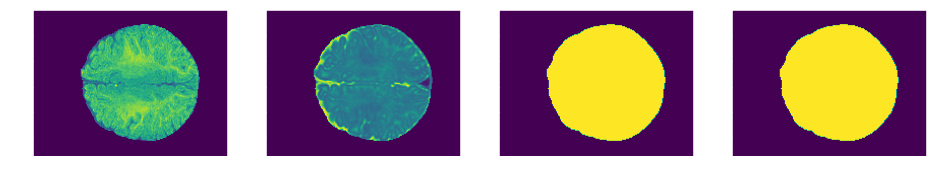

T1, T2, Prediction, Verite Terrain


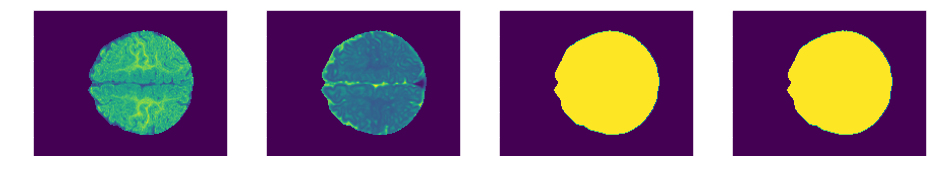

T1, T2, Prediction, Verite Terrain


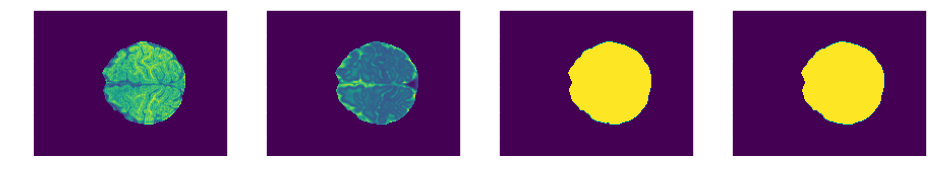

T1, T2, Prediction, Verite Terrain


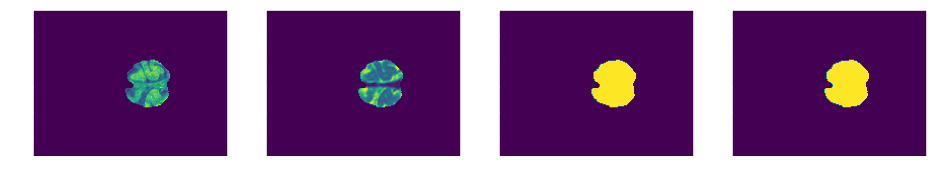

CardIntersec = 804592
CardX = 804777
CardY = 810594
Dice =  0.9961699200988503


IndexError: index 2 is out of bounds for axis 0 with size 2

In [19]:
nb_patient = 0
new_nb_patient_test = 0
list_dice_crane = np.zeros((nb_patient_test,))

for filename in filenames:
    if "label" in filename and "hdr" not in filename:
        if nb_patient <= nb_patient_training + nb_patient_validation and nb_patient < nb_patient_training + nb_patient_validation + nb_patient_test:
            print("PATIENT (test):", filename)
            T1_name = filename[:-10] + "-T1.img"
            T1 = nib.load(T1_name).get_fdata()
            T2_name = filename[:-10] + "-T2.img"
            T2 = nib.load(T2_name).get_fdata()
            labels = nib.load(filename).get_fdata()
                
            sx, sy, sz, _ = labels.shape
            labels = np.array(labels).reshape((sx, sy, sz))
                
            prediction3D_10 = np.zeros((sx, sy, sz))
                
            T1_normalized = Normalisation(T1).reshape((sx, sy, sz))
            T2_normalized = Normalisation(T2).reshape((sx, sy, sz))
            VT10 = np.where(labels >= 10, 1, 0)
                
            for z in range(0, sz):
                input_network = np.zeros((1, sx, sy, 2))
                input_network[0, :, :, 0] = T1_normalized[:, :, z]
                input_network[0, :, :, 1] = T2_normalized[:, :, z]
                pred = model_step1.predict(input_network, verbose=0).reshape((sx, sy))
                prediction10 = np.round(pred)
                prediction3D_10[:, :, z] = np.copy(prediction10)
                    
                # Display
                prediction_to_plot = np.copy(prediction10)
                VT_to_plot = np.copy(VT10[:, :, z])
                if z % 10 == 0 and np.sum(VT_to_plot) > 0:
                    VT_to_plot[0, 0] = 1.0 
                    prediction_to_plot[0, 0] = 1.0
                    print("T1, T2, Prediction, Verite Terrain")
                    fast_display(T1_normalized[:, :, z].reshape((sx, sy)), T2_normalized[:, :, z].reshape((sx, sy)), prediction_to_plot, VT_to_plot)
            dice = ComputeDice(prediction3D_10, VT10)
            list_dice_crane[new_nb_patient_test] = dice
            new_nb_patient_test += 1 
        nb_patient += 1

In [20]:
print(list_dice_crane)

[0.99621325 0.99600394]
